In [85]:
from keras import backend as K

In [86]:
import numpy as np
import pandas as pd

In [87]:
import keras

# Indodax Data Retrieval

In [88]:
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [89]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'
period = '5'
time_begin = int(datetime.datetime(2016, 1, 1).timestamp())
time_end = int(datetime.datetime(2016, 9, 1).timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)
price = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
# }, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)).strftime('%d/%m %H.%M'), r.json()['t'])))
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
len(price)

70273

In [90]:
price.head()

,open,close,high,low,volume
2016-01-01 00:00:00,5820000,5826100,5843200,5819900,9.055471
2016-01-01 00:05:00,5826100,5825700,5840000,5825600,1.724304
2016-01-01 00:10:00,5825700,5829800,5829900,5825700,4.507918
2016-01-01 00:15:00,5829800,5821200,5829800,5821000,2.371822
2016-01-01 00:20:00,5821200,5824900,5824900,5821200,0.830288


In [91]:
action_list = {}
action_list['\\'] = {'action'}
action_list['action'] = []

# weird workaround due to limitation to column name, see below
# HOLD --> 0
# BUY --> -1
# SELL --> 1
for i in range(len(price.index)-1):
    current = price.iloc[i]
    before = price.iloc[i-1]
    after = price.iloc[i+1]
    if current.close < after.close:
        if current.close > before.close:
            action_list['action'].append(0)
        else:
            action_list['action'].append(-1)
    elif current.close > after.close:
        if current.close < before.close:
            action_list['action'].append(0)
        else:
            action_list['action'].append(1)
    else:
        action_list['action'].append(0)
action_list['action'].append(0)
action_frame = pd.DataFrame(action_list['action']).set_index(price.index)

# we need the stock price somehow
action_frame = action_frame.join(price)

# column names change 'Action' to 'low'
# weird workaround due to limitation to column name
# reference : https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed.html?highlight=pandasdata
action_frame.columns = ['low', 'open', 'close', 'high', 'real_low', 'volume']

In [92]:
action_frame.head()

,low,open,close,high,real_low,volume
2016-01-01 00:00:00,0,5820000,5826100,5843200,5819900,9.055471
2016-01-01 00:05:00,-1,5826100,5825700,5840000,5825600,1.724304
2016-01-01 00:10:00,1,5825700,5829800,5829900,5825700,4.507918
2016-01-01 00:15:00,-1,5829800,5821200,5829800,5821000,2.371822
2016-01-01 00:20:00,1,5821200,5824900,5824900,5821200,0.830288


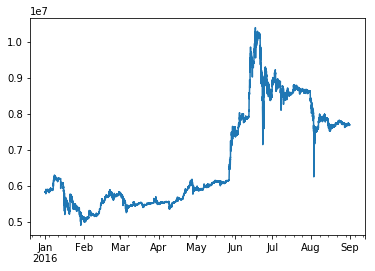

In [122]:
df_train = price['close']
x = np.array([i*5 for i in range(len(df_train))])
x = x.reshape(-1,1)
y = [i for i in df_train]
df_train.plot()

In [105]:
from sklearn.linear_model import LinearRegression

t_forward = 20
label = [0 for i in range(t_forward)]
kof = []
for i in range(t_forward, len(df_train)):
    reg = LinearRegression()
    x_tmp = x[i-t_forward:i]
    y_tmp = y[i-t_forward:i]
    reg.fit(x_tmp, y_tmp)
    
    coef = reg.coef_[0]
#     print(coef)
    if coef > 3000:
        label.append(-1)
    elif coef < -3000:
        label.append(1)
    else:
        label.append(0)

In [106]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 178
hold 69875
sell 220


In [107]:
import backtrader as bt
import backtrader.feeds as btfeeds
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # weird workaround due to limitation to column name
        # we take the low column as action
        self.data_action = self.datas[0].low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.opsize = order.executed.size
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                gross_pnl = (order.executed.price - self.buyprice) * \
                    self.opsize

                net_pnl = gross_pnl - self.buycomm - order.executed.comm
                self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                         (gross_pnl, net_pnl))


            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy!
            if self.data_action[0] == -1:
                self.log('BUY CREATE')
                self.order = self.buy()

        else:
            # sell!
            if self.data_action[0] == 1:
                self.log('SELL CREATE')
                self.order = self.sell()

In [108]:
action_frame['low'] = label
action_frame.head()

,low,open,close,high,real_low,volume
2016-01-01 00:00:00,0,5820000,5826100,5843200,5819900,9.055471
2016-01-01 00:05:00,0,5826100,5825700,5840000,5825600,1.724304
2016-01-01 00:10:00,0,5825700,5829800,5829900,5825700,4.507918
2016-01-01 00:15:00,0,5829800,5821200,5829800,5821000,2.371822
2016-01-01 00:20:00,0,5821200,5824900,5824900,5821200,0.830288


In [109]:
commission = 0.003
data_feed = btfeeds.PandasData(dataname=action_frame, openinterest=None)

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
# cerebro.adddata(action_frame)
cerebro.broker.setcash(100000000.0)
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

Starting Portfolio Value: 100000000.00
2016-01-16, BUY CREATE
2016-01-16, BUY EXECUTED, Price: 5649100.00, Cost: 5649100.00, Comm 16947.30
2016-05-29, SELL CREATE
2016-05-29, SELL EXECUTED, Price: 7199900.00, Cost: 5649100.00, Comm 21599.70
2016-05-29, OPERATION PROFIT, GROSS 1550800.00, NET 1512253.00
2016-06-12, BUY CREATE
2016-06-12, BUY EXECUTED, Price: 8339900.00, Cost: 8339900.00, Comm 25019.70
2016-06-13, SELL CREATE
2016-06-13, SELL EXECUTED, Price: 9316900.00, Cost: 8339900.00, Comm 27950.70
2016-06-13, OPERATION PROFIT, GROSS 977000.00, NET 924029.60
2016-06-13, BUY CREATE
2016-06-13, BUY EXECUTED, Price: 9849900.00, Cost: 9849900.00, Comm 29549.70
2016-06-13, SELL CREATE
2016-06-13, SELL EXECUTED, Price: 9531300.00, Cost: 9849900.00, Comm 28593.90
2016-06-13, OPERATION PROFIT, GROSS -318600.00, NET -376743.60
2016-06-15, BUY CREATE
2016-06-15, BUY EXECUTED, Price: 9376900.00, Cost: 9376900.00, Comm 28130.70
2016-06-17, SELL CREATE
2016-06-17, SELL EXECUTED, Price: 9959800.00

In [57]:
t_forward = 20
data_frame = []
for i in range(t_forward, len(df_train)-t_forward):
    to_append = price['close'][i-t_forward:i+t_forward]
    data_frame.append(to_append)

columns = []
now = -t_forward+1
for i in range(2*t_forward):
    if now != 0:
        columns.append('t'+str(now))
    else:
        columns.append('t')
    now += 1

data_frame = pd.DataFrame(np.array(data_frame), columns=columns)

In [58]:
data_frame.head()

,t-19,t-18,t-17,t-16,t-15,t-14,t-13,t-12,t-11,t-10,...,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20
0,5826100,5825700,5829800,5821200,5824900,5821000,5818000,5821600,5849000,5849800,...,5820100,5820200,5820200,5820100,5820100,5829900,5829900,5840000,5844100,5821200
1,5825700,5829800,5821200,5824900,5821000,5818000,5821600,5849000,5849800,5816100,...,5820200,5820200,5820100,5820100,5829900,5829900,5840000,5844100,5821200,5821200
2,5829800,5821200,5824900,5821000,5818000,5821600,5849000,5849800,5816100,5820000,...,5820200,5820100,5820100,5829900,5829900,5840000,5844100,5821200,5821200,5821200
3,5821200,5824900,5821000,5818000,5821600,5849000,5849800,5816100,5820000,5843500,...,5820100,5820100,5829900,5829900,5840000,5844100,5821200,5821200,5821200,5821300
4,5824900,5821000,5818000,5821600,5849000,5849800,5816100,5820000,5843500,5843600,...,5820100,5829900,5829900,5840000,5844100,5821200,5821200,5821200,5821300,5844400


In [59]:
from sklearn.model_selection import train_test_split

feature_cols = columns[:t_forward]
y_columns = columns[t_forward:]
x = data_frame[feature_cols]
y = data_frame[y_columns]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=False)
x_train.head()

,t-19,t-18,t-17,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,5826100,5825700,5829800,5821200,5824900,5821000,5818000,5821600,5849000,5849800,5816100,5820000,5843500,5843600,5835300,5845700,5845800,5845700,5845800,5845700
1,5825700,5829800,5821200,5824900,5821000,5818000,5821600,5849000,5849800,5816100,5820000,5843500,5843600,5835300,5845700,5845800,5845700,5845800,5845700,5845700
2,5829800,5821200,5824900,5821000,5818000,5821600,5849000,5849800,5816100,5820000,5843500,5843600,5835300,5845700,5845800,5845700,5845800,5845700,5845700,5845000
3,5821200,5824900,5821000,5818000,5821600,5849000,5849800,5816100,5820000,5843500,5843600,5835300,5845700,5845800,5845700,5845800,5845700,5845700,5845000,5844800
4,5824900,5821000,5818000,5821600,5849000,5849800,5816100,5820000,5843500,5843600,5835300,5845700,5845800,5845700,5845800,5845700,5845700,5845000,5844800,5844400


In [64]:
regs = [LinearRegression() for i in range(t_forward)]
for i in range(len(regs)):
    reg = regs[i]
    reg.fit(x_train, y_train[y_columns[i]])
    print(reg.score(x_test, y_test[y_columns[i]]))

0.9985685237319624
0.99767491645555
0.9969073045366529
0.9961659600021391
0.9954302888280451
0.9946904366190777
0.9940052069583877
0.9933396884330291
0.9926174622104327
0.9918927766513085
0.9911350924007597
0.9904687246552999
0.9897783224339934
0.9890705773438008
0.9883885434298703
0.9877911978152396
0.9872244391583078
0.9866486365118676
0.9861066297654361
0.985530313272355


In [123]:
from statistics import mean
label = []

for i in range(len(x_test)):
    feat = x_test[i:i+1]
    
    feature_ext = []
    for j in feature_cols:
        now = feat[j]
        for tmp in now:
            feature_ext.append(tmp)

    predict = [regs[i].predict(feat)[0] for i in range(t_forward)]

    prev_mean = mean(feature_ext)
    predict_mean = mean(predict)
    predict_mean_commision = 0.003*predict_mean
#     print(predict_mean-prev_mean)
    
    if predict_mean-prev_mean-predict_mean_commision > 60000:
        label.append(-1)
    elif predict_mean-prev_mean+predict_mean_commision < -50000:
        label.append(1)
    else:
        label.append(0)

In [124]:
print('buy', len(list(filter(lambda p: p == -1, label))))
print('hold', len(list(filter(lambda p: p == 0, label))))
print('sell', len(list(filter(lambda p: p == 1, label))))

buy 305
hold 20375
sell 390


In [125]:
new_action_frame = action_frame[-len(label):]
new_action_frame['low'] = label
new_action_frame.head()

/home/sangbijaksana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,low,open,close,high,real_low,volume
2016-06-19 20:15:00,0,10194100,10173100,10194200,10173000,0.809590
2016-06-19 20:20:00,0,10173100,10173000,10175800,10173000,0.190078
2016-06-19 20:25:00,0,10173000,10173500,10174500,10173000,0.337473
2016-06-19 20:30:00,0,10173500,10173000,10173500,10173000,0.274173
2016-06-19 20:35:00,0,10173000,10193000,10193300,10173000,1.251532


In [126]:
commission = 0.003
data_feed = btfeeds.PandasData(dataname=new_action_frame, openinterest=None)

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
# cerebro.adddata(action_frame)
cerebro.broker.setcash(100000000.0)
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

Starting Portfolio Value: 100000000.00
2016-06-21, BUY CREATE
2016-06-21, BUY EXECUTED, Price: 9699900.00, Cost: 9699900.00, Comm 29099.70
2016-06-21, SELL CREATE
2016-06-21, SELL EXECUTED, Price: 9328900.00, Cost: 9699900.00, Comm 27986.70
2016-06-21, OPERATION PROFIT, GROSS -371000.00, NET -428086.40
2016-06-22, BUY CREATE
2016-06-22, BUY EXECUTED, Price: 9152000.00, Cost: 9152000.00, Comm 27456.00
2016-06-22, SELL CREATE
2016-06-22, SELL EXECUTED, Price: 8999900.00, Cost: 9152000.00, Comm 26999.70
2016-06-22, OPERATION PROFIT, GROSS -152100.00, NET -206555.70
2016-06-22, BUY CREATE
2016-06-22, BUY EXECUTED, Price: 9044300.00, Cost: 9044300.00, Comm 27132.90
2016-06-22, SELL CREATE
2016-06-22, SELL EXECUTED, Price: 8977900.00, Cost: 9044300.00, Comm 26933.70
2016-06-22, OPERATION PROFIT, GROSS -66400.00, NET -120466.60
2016-06-22, BUY CREATE
2016-06-22, BUY EXECUTED, Price: 9049900.00, Cost: 9049900.00, Comm 27149.70
2016-06-22, SELL CREATE
2016-06-22, SELL EXECUTED, Price: 9046000.0